# Impact of age of enrollment on the Five Domains of Speech-Language in Children with Hearing Loss at age 4 years

Paper 2

In [1]:
# Import modules and set options
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
from pathlib import Path

sns.set(context='notebook', style='ticks')

Import data

In [2]:
lsl_dr = (pd.read_csv(str(Path.home()) + '/infant_hearing_intervention/data/clean/lsl_dr_frozen_09272019.csv', low_memory=False)
                  .rename({'onset_1':'identify_mo'}, axis=1))

In [3]:
lsl_dr.head()

,redcap_event_name,academic_year_rv,hl,male,_race,prim_lang,sib,_mother_ed,father_ed,par1_ed,...,gf3_siw_ss,gf_version,ppvt_f,ppvt_ss,rowpvt_ss,school,score,test_name,test_type,score_adj
0,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,101,58.0,NaN,EOWPVT,59.847785
1,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,101,51.0,PLS,receptive,48.176390
2,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,101,60.0,PLS,expressive,57.345971
3,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,101,54.0,PLS,total,51.232917
4,initial_assessment_arm_1,2011.0,0.0,0.0,2.0,0.0,1.0,5.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,626,50.0,PLS,receptive,50.000000


Indicator for non-profound hearing loss

In [4]:
lsl_dr['deg_hl_below6'] = lsl_dr.degree_hl<6
lsl_dr.loc[lsl_dr.degree_hl.isnull(), 'deg_hl_below6'] = np.nan

Indicator for first intervention outside OPTION

In [5]:
lsl_dr['int_outside_option'] = lsl_dr.age > lsl_dr.age_int
lsl_dr.loc[lsl_dr.age < lsl_dr.age_int, 'int_outside_option'] = np.nan

Indicator for high school graduation of mother

In [6]:
lsl_dr['mother_college'] = lsl_dr.mother_ed >= 3
lsl_dr.loc[lsl_dr.mother_ed.isnull(), 'mother_college'] = None

Create age in years variable

In [7]:
lsl_dr['age_years'] = lsl_dr.age/12.

Create school index

In [8]:
schools_unique = np.sort(lsl_dr.school.unique())
school_lookup = dict(zip(schools_unique, range(len(schools_unique))))

In [9]:
lsl_dr['school_idx'] = lsl_dr.school.replace(school_lookup)

Create student index

In [10]:
student_unique = np.sort(lsl_dr.study_id.unique())
student_lookup = dict(zip(student_unique, range(len(student_unique))))

In [11]:
lsl_dr['student_idx'] = lsl_dr.study_id.replace(student_lookup)

Add expressive and receptive to langauge test domains

In [12]:
lsl_dr.loc[(lsl_dr.domain=='Language') & (lsl_dr.test_type=='receptive'), 
           'domain'] = 'Receptive Language'
lsl_dr.loc[(lsl_dr.domain=='Language') & (lsl_dr.test_type=='expressive'), 
           'domain'] = 'Expressive Language'
lsl_dr.loc[(lsl_dr.domain=='Language') & (lsl_dr.test_type=='total'), 
           'domain'] = 'Total Language'

In [13]:
lsl_dr['ident_3mo'] = lsl_dr.identify_mo <=3
lsl_dr.loc[lsl_dr.identify_mo.isnull(), 'ident_3mo'] = None
lsl_dr['int_6mo'] = lsl_dr.age_int <= 6
lsl_dr.loc[lsl_dr.identify_mo.isnull(), 'int_6mo'] = None

Drop records with missing race and age at ernollment, since there is less than 1% of them

In [14]:
lsl_dr = lsl_dr.dropna(subset=['race', 'age_years', 'int_outside_option'])

### Exclusions

Drop non-english and other disabilities, filter for hearing loss

In [15]:
other_etiology = (lsl_dr[['etiology_3___2', 'etiology_3___4', 'etiology_3___5', 'etiology_3___6', 'etiology_3___9',
       'etiology_oth___1', 'etiology_oth___3', 'etiology_oth___4', 'etiology_oth___8', 'etiology_oth___9']]
                      .sum(1).astype(bool))
NON_ENGLISH = lsl_dr.non_english.astype(bool) 

In [16]:
SECONDARY_DISABILITY = (lsl_dr.synd_or_disab.astype(bool) 
     | ~(lsl_dr.etiology_2.isin([0,4]))
     | (lsl_dr.etiology_2.isnull() & other_etiology))

In [17]:
# no secondary distability, english first language
inclusion_mask_1 = ((lsl_dr.degree_hl!=0)
                  & ~SECONDARY_DISABILITY
                  & ~NON_ENGLISH)

# secondary disability, english first language
inclusion_mask_2 = ((lsl_dr.degree_hl!=0)
                  & SECONDARY_DISABILITY
                  & ~NON_ENGLISH)

# no secondary disability, non-english
inclusion_mask_3 = ((lsl_dr.degree_hl!=0)
                  & ~SECONDARY_DISABILITY
                  & NON_ENGLISH)

# secondary disability, non-english
inclusion_mask_4 = ((lsl_dr.degree_hl!=0)
                  & SECONDARY_DISABILITY
                  & NON_ENGLISH)

In [18]:
masks = {'no secondary disability, english': inclusion_mask_1, 
         'secondary disability, english': inclusion_mask_2, 
         'no secondary disability, non-english': inclusion_mask_3, 
         'secondary disability, non-english': inclusion_mask_4}

In [19]:
covariates = ['score_adj', 'student_idx', 'school_idx', 'male', 'sib', 'family_inv', 'race', 'age_test', 
              'domain', 'deg_hl_below6', 'mother_college', 'age_years', 'test_type', 'time', 'bilateral_ci',
              'bilateral_ha', 'unilateral_ci', 'unilateral_ha', 'bimodal', 'age_amp',
              'ident_3mo', 'int_outside_option', 'int_6mo']

In [20]:
group = 'no secondary disability, english'
filename_stub = ''

In [21]:
analysis_subset = lsl_dr.loc[masks[group], covariates].copy().dropna(subset=['time', 'score_adj', 'age_test']) 
analysis_subset.shape[0]

31454

In [22]:
unique_students = analysis_subset.drop_duplicates(subset='student_idx')
unique_students.shape[0]

3074

In [23]:
null_prop = analysis_subset.isnull().mean()
null_prop[null_prop>0].round(2).sort_values(ascending=False)

mother_college    0.25
age_amp           0.15
int_6mo           0.12
ident_3mo         0.12
family_inv        0.09
deg_hl_below6     0.07
sib               0.05
dtype: float64

## Model specification

In [24]:
def fillna(x, value):
    x_masked = np.ma.masked_invalid(x)
    np.ma.set_fill_value(x_masked, value)
    return x_masked

fillna(np.array([0.4, np.nan, 5]), 0.5)

masked_array(data=[0.4, --, 5.0],
             mask=[False,  True, False],
       fill_value=0.5)

In [29]:
from pymc3 import Bernoulli, Normal, Uniform, Dirichlet, Categorical, Beta, HalfCauchy
from pymc3 import Gamma, Exponential, Multinomial, HalfNormal, NormalMixture, Lognormal
from pymc3 import Model, Deterministic, Metropolis
from pymc3 import sample

from numpy.ma import masked_values, set_fill_value, masked_invalid
import theano.tensor as tt
from theano import shared

def generate_model(dataset, cohort_age=4):
    
    if cohort_age==2:
        mask = (dataset.age_test>=24) & (dataset.age_test<36)
    elif cohort_age==3:
        mask = (dataset.age_test>=36) & (dataset.age_test<48)
    elif cohort_age==4:
        mask = (dataset.age_test>=48) & (dataset.age_test<60)
    elif cohort_age==5:
        mask = (dataset.age_test>=60) & (dataset.age_test<72)
    elif cohort_age==6:
        mask = (dataset.age_test>=72) & (dataset.age_test<84)
    else:
        print('Invalid age!')
        return
    
    # Generate mean scores
    cohort_dataset = dataset[mask]
    dataset_unique = cohort_dataset.loc[cohort_dataset.groupby('student_idx').age_test.idxmax()]

    assert not dataset_unique.score_adj.isnull().sum()
#     mean_scores = dataset[mask].groupby('student_idx').score.mean()
#     dataset_unique = dataset[mask].drop_duplicates(subset='student_idx')
#     dataset_unique.set_index('student_idx').drop('score', axis=1).join(mean_scores)
#     assert not dataset_unique.score.isnull().sum()
    
    (family_inv, school, 
     time, sib,
     mother_college, age_amp,
     ident_3mo, int_outside_option, 
     int_6mo, score) = dataset_unique[['family_inv', 'school_idx',  
                                       'time', 'sib', 
                                       'mother_college','age_amp', 
                                       'ident_3mo', 'int_outside_option', 
                                       'int_6mo', 'score_adj']].astype(float).T.values

    int_option = (~int_outside_option.astype(bool)).astype(int)

    with Model() as model:
        
        # Imputation of age of amplification
        if np.isnan(age_amp).sum():
            m_age_amp = Normal("m_age_amp", 0, sd=5, shape=2)
            s_age_amp = Exponential("s_age_amp", 1)
            p_age_amp = Beta('p_age_amp', 1, 1)
            _x_age_amp = NormalMixture('x_age_amp', [p_age_amp, 1-p_age_amp], m_age_amp, 
                                       sd=s_age_amp,
                                       observed=masked_invalid(np.log(age_amp+0.1)))
            x_age_amp = (tt.exp(_x_age_amp) - 0.1) / 12
        else:
            x_age_amp = age_amp / 12
        
        # Imputation of family involvement
        if np.isnan(family_inv).sum():
            p_family_inv = Dirichlet("p_family_inv", np.ones(5))
            x_family_inv = Categorical('x_family_inv', p_family_inv, 
                                       observed=masked_invalid(family_inv))
        else:
            x_family_inv = family_inv
            
        # Imputation of siblings
        if np.isnan(sib).sum():
            n_sib_cats = len(dataset.sib.unique())
            p_sib = Dirichlet("p_sib", np.ones(n_sib_cats))
            x_sib = Categorical('x_sib', p_sib, observed=masked_invalid(sib))
        else:
            x_sib = sib
            
        # Imputation of 3 month identification
        if np.isnan(ident_3mo).sum():
            p_3mo = Beta("p_3mo", 1, 1)
            x_3mo = Bernoulli('x_3mo', p_3mo, observed=masked_invalid(ident_3mo))
        else:
            x_3mo = ident_3mo
            
        # Imputation of 6 month intervention
        if np.isnan(int_6mo).sum():
            p_6mo = Beta("p_6mo", 1, 1)
            x_6mo = Bernoulli('x_6mo', p_6mo, observed=masked_invalid(int_6mo))
        else:
            x_6mo = int_6mo
            
        # Imputation of mother's college education
        if np.isnan(mother_college).sum():
            p_mother_college = Beta("p_mother_college", 1, 1)
            x_mother_college = Bernoulli('x_mother_college', p_mother_college, observed=masked_invalid(mother_college))
        else:
            x_mother_college = mother_college
            
        # Indices to school random effects
        unique_schools = np.unique(school)
        school_index = [list(unique_schools).index(s) for s in school]

        # School random effect (non-centered parameterization)
        μ_school = Normal('μ_school', 90, sd=10)
        σ_school = HalfCauchy("σ_school", 1)
        z_school = Normal('z_school', mu=0, sd=1, shape=len(unique_schools))
        α_school = μ_school + z_school*σ_school
        
        # Random intercepts
        intercept = α_school[school_index]

        # Covariates
        X = [x_age_amp, 
             x_family_inv, 
             x_sib,
             x_mother_college, 
             time,
             x_3mo,
             x_6mo,
             int_option,
             int_option*x_6mo]

        assert not np.isnan(time).any()
        assert not np.isnan(int_option).any()


        # Fixed effects
        β = Normal("β", 0, sd=10, shape=len(X))
        θ = intercept + β.dot(tt.stack(X))
        σ = HalfNormal("σ", sd=25)
        score_like = Normal("score_like", mu=θ, sd=σ, observed=score)

        option_after_6mo = Deterministic('option_after_6mo', β[-3:].sum())


    return model

## Receptive Language Test Score Model

In [26]:
receptive_language_dataset = analysis_subset[(analysis_subset.domain=='Receptive Language')]

receptive_language_dataset.shape[0]

6047

In [27]:
receptive_language_4 = generate_model(receptive_language_dataset, 4)

/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_age_amp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_family_inv contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_sib contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_3mo contains missing values and will be automatically impu

In [26]:
iterations = 1000
tuning = 4000

In [29]:
CHECK_MODEL = True

if CHECK_MODEL:
    print(receptive_language_4.check_test_point())

m_age_amp                         -5.06
s_age_amp_log__                   -1.06
p_age_amp_logodds__               -1.39
x_age_amp_missing                  0.00
p_family_inv_stickbreaking__      -4.87
x_family_inv_missing               0.00
p_sib_stickbreaking__             -4.87
x_sib_missing                      0.00
p_3mo_logodds__                   -1.39
x_3mo_missing                      0.00
p_6mo_logodds__                   -1.39
x_6mo_missing                      0.00
p_mother_college_logodds__        -1.39
x_mother_college_missing           0.00
μ_school                          -3.22
σ_school_log__                    -1.14
z_school                         -37.68
β                                -28.99
σ_log__                           -0.77
x_age_amp                      -6490.98
x_family_inv                   -1654.50
x_sib                          -1654.50
x_3mo                           -712.56
x_6mo                           -712.56
x_mother_college                -712.56


In [30]:
with receptive_language_4:
    rec_lang_4_trace = sample(iterations, tune=tuning, chains=2, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [σ, β, z_school, σ_school, μ_school, p_mother_college, p_6mo, p_3mo, p_sib, p_family_inv, x_age_amp_missing, p_age_amp, s_age_amp, m_age_amp]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_3mo_missing, x_6mo_missing, x_mother_college_missing]


In [27]:
labels = ['Age at amplification',
          'Family Involvement Score', 
          'Number of siblings',
          'Mother with College Ed',
          'Years in program',
          'Identified <= 3mo',          
          'Intervention <= 6mo',
          'Intervention with OPTION',
          'Interaction']

In [28]:
x_range = -10, 15

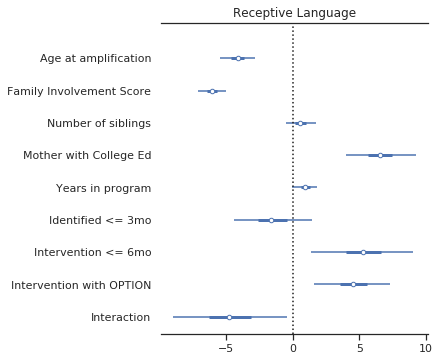

In [33]:
_,axes = az.plot_forest(rec_lang_4_trace, 
               var_names=['β'],
              combined=True)
axes[0].set_title('Receptive Language')
axes[0].vlines(0, *axes[0].get_ylim(), linestyles='dotted')
axes[0].set_yticklabels(labels[::-1]);

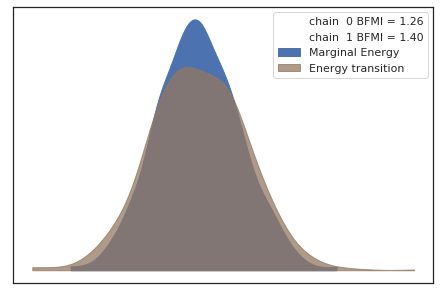

In [34]:
az.plot_energy(rec_lang_4_trace)

The school random effect standard deviation is a measure of how variable scores are among schools. The estimated standard deviation is about 4 points for this domain.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab19e871d0>,
      dtype=object)

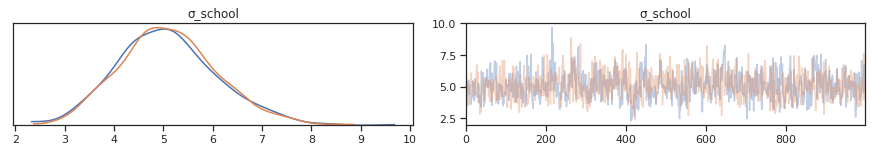

In [35]:
az.plot_trace(rec_lang_4_trace, var_names=['σ_school'])

In [73]:
rec_lang_table = az.summary(rec_lang_4_trace, 
                            var_names=['β', 'option_after_6mo']).set_index(pd.Index(labels + ['OPTION < 6mo'])).iloc[:, :4]
rec_lang_table

,mean,sd,hpd_3%,hpd_97%
Age at amplification,-4.101,0.699,-5.411,-2.825
Family Involvement Score,-6.016,0.557,-7.039,-4.960
Number of siblings,0.594,0.604,-0.516,1.765
Mother with College Ed,6.540,1.382,4.036,9.240
Years in program,0.959,0.522,-0.066,1.865
Identified <= 3mo,-1.537,1.584,-4.377,1.468
Intervention <= 6mo,5.268,2.004,1.356,9.004
Intervention with OPTION,4.582,1.485,1.607,7.288
Interaction,-4.728,2.328,-8.951,-0.410
OPTION < 6mo,5.121,2.264,1.059,9.348


In [74]:
rec_lang_table.to_csv('rec_lang_EI.csv')

## Expressive Language Model

In [41]:
expressive_language_dataset = analysis_subset[(analysis_subset.domain=='Expressive Language')]

In [42]:
expressive_language_4 = generate_model(expressive_language_dataset, 4)

/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_age_amp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_family_inv contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_sib contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_3mo contains missing values and will be automatically impu

In [43]:
with expressive_language_4:
    
    exp_lang_4_trace = sample(iterations, tune=tuning)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ, β, z_school, σ_school, μ_school, p_mother_college, p_6mo, p_3mo, p_sib, p_family_inv, x_age_amp_missing, p_age_amp, s_age_amp, m_age_amp]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_3mo_missing, x_6mo_missing, x_mother_college_missing]


The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


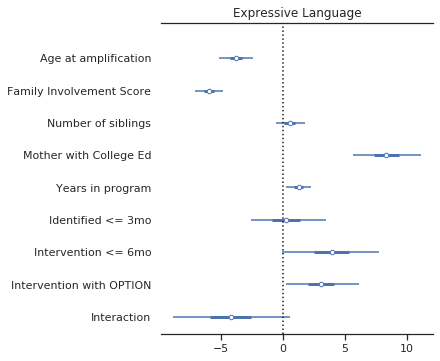

In [44]:
_,axes = az.plot_forest(exp_lang_4_trace, 
               var_names=['β'],
              combined=True)
axes[0].set_title('Expressive Language')
axes[0].vlines(0, *axes[0].get_ylim(), linestyles='dotted')
axes[0].set_yticklabels(labels[::-1]);

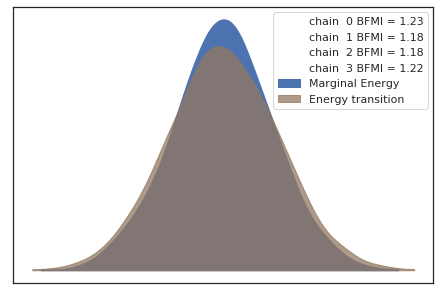

In [45]:
az.plot_energy(exp_lang_4_trace)

In [75]:
exp_lang_table = az.summary(exp_lang_4_trace, 
                            var_names=['β', 'option_after_6mo']).set_index(pd.Index(labels + ['OPTION < 6mo'])).iloc[:, :4]
exp_lang_table

,mean,sd,hpd_3%,hpd_97%
Age at amplification,-3.772,0.735,-5.164,-2.434
Family Involvement Score,-5.942,0.606,-7.054,-4.811
Number of siblings,0.564,0.620,-0.540,1.775
Mother with College Ed,8.350,1.477,5.648,11.122
Years in program,1.292,0.538,0.297,2.284
Identified <= 3mo,0.308,1.639,-2.582,3.490
Intervention <= 6mo,3.921,2.091,-0.055,7.720
Intervention with OPTION,3.069,1.558,0.269,6.155
Interaction,-4.185,2.480,-8.833,0.577
OPTION < 6mo,2.805,2.387,-1.740,7.240


In [76]:
exp_lang_table.to_csv('exp_lang_EI.csv')

## Total Language

In [48]:
total_language_dataset = analysis_subset[(analysis_subset.domain=='Total Language')]
total_language_dataset.shape

(6205, 23)

In [49]:
total_language_4 = generate_model(total_language_dataset, 4)

/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_age_amp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_family_inv contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_sib contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_3mo contains missing values and will be automatically impu

In [50]:
with total_language_4:
    
    total_lang_4_trace = sample(iterations, tune=tuning)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ, β, z_school, σ_school, μ_school, p_mother_college, p_6mo, p_3mo, p_sib, p_family_inv, x_age_amp_missing, p_age_amp, s_age_amp, m_age_amp]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_3mo_missing, x_6mo_missing, x_mother_college_missing]


The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


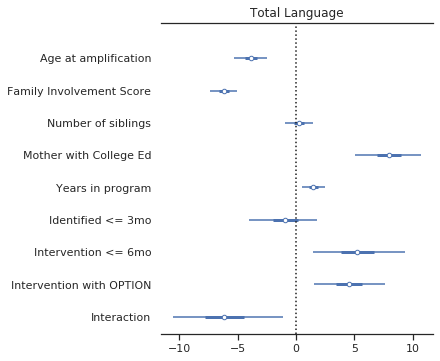

In [51]:
_,axes = az.plot_forest(total_lang_4_trace, 
               var_names=['β'],
              combined=True)
axes[0].set_title('Total Language')
axes[0].vlines(0, *axes[0].get_ylim(), linestyles='dotted')
axes[0].set_yticklabels(labels[::-1]);

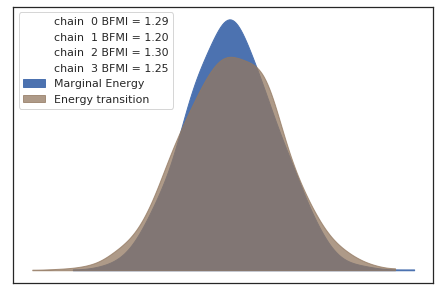

In [52]:
az.plot_energy(total_lang_4_trace)

In [77]:
total_lang_table = az.summary(total_lang_4_trace, 
                              var_names=['β', 'option_after_6mo']).set_index(pd.Index(labels + ['OPTION < 6mo'])).iloc[:, :4]
total_lang_table

,mean,sd,hpd_3%,hpd_97%
Age at amplification,-3.850,0.753,-5.307,-2.484
Family Involvement Score,-6.190,0.621,-7.354,-5.035
Number of siblings,0.248,0.637,-0.976,1.418
Mother with College Ed,7.979,1.523,5.045,10.691
Years in program,1.487,0.533,0.471,2.467
Identified <= 3mo,-0.940,1.575,-3.993,1.838
Intervention <= 6mo,5.238,2.108,1.468,9.342
Intervention with OPTION,4.529,1.641,1.501,7.628
Interaction,-6.099,2.498,-10.531,-1.107
OPTION < 6mo,3.668,2.367,-0.920,7.992


In [78]:
total_lang_table.to_csv('total_lang_EI.csv')

## Articulation Model

In [55]:
articulation_dataset = analysis_subset[(analysis_subset.domain=='Articulation')]

In [56]:
articulation_4 = generate_model(articulation_dataset, 4)

/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_age_amp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_family_inv contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_sib contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_3mo contains missing values and will be automatically impu

In [57]:
with articulation_4:
    
    artic_4_trace = sample(iterations, tune=tuning)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ, β, z_school, σ_school, μ_school, p_mother_college, p_6mo, p_3mo, p_sib, p_family_inv, x_age_amp_missing, p_age_amp, s_age_amp, m_age_amp]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_3mo_missing, x_6mo_missing, x_mother_college_missing]


The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


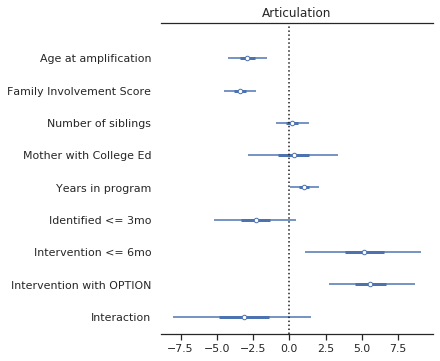

In [58]:
_,axes = az.plot_forest(artic_4_trace, 
               var_names=['β'],
              combined=True)
axes[0].set_title('Articulation')
axes[0].vlines(0, *axes[0].get_ylim(), linestyles='dotted')
axes[0].set_yticklabels(labels[::-1]);

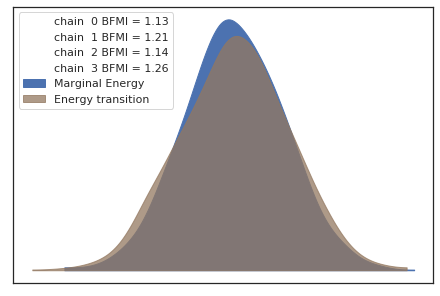

In [59]:
az.plot_energy(artic_4_trace)

In [79]:
artic_table = az.summary(artic_4_trace, 
                         var_names=['β', 'option_after_6mo']).set_index(pd.Index(labels + ['OPTION < 6mo'])).iloc[:, :4]
artic_table

,mean,sd,hpd_3%,hpd_97%
Age at amplification,-2.896,0.721,-4.229,-1.537
Family Involvement Score,-3.389,0.592,-4.493,-2.271
Number of siblings,0.200,0.610,-0.926,1.368
Mother with College Ed,0.275,1.637,-2.853,3.370
Years in program,1.017,0.528,0.034,2.006
Identified <= 3mo,-2.322,1.502,-5.172,0.461
Intervention <= 6mo,5.119,2.093,1.081,9.057
Intervention with OPTION,5.594,1.587,2.710,8.675
Interaction,-3.137,2.552,-8.019,1.490
OPTION < 6mo,7.575,2.286,3.143,11.694


In [80]:
artic_table.to_csv('artic_EI.csv')

## Expressive Vocabulary Model

In [62]:
expressive_vocab_dataset = analysis_subset[(analysis_subset.domain=='Expressive Vocabulary')]

In [63]:
expressive_vocab_4 = generate_model(expressive_vocab_dataset, 4)

/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_age_amp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_family_inv contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_sib contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_3mo contains missing values and will be automatically impu

In [64]:
with expressive_vocab_4:
    
    expressive_vocab_4_trace = sample(iterations, tune=tuning)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ, β, z_school, σ_school, μ_school, p_mother_college, p_6mo, p_3mo, p_sib, p_family_inv, x_age_amp_missing, p_age_amp, s_age_amp, m_age_amp]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_3mo_missing, x_6mo_missing, x_mother_college_missing]


The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


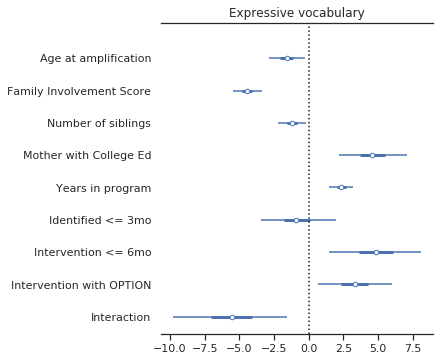

In [65]:
_,axes = az.plot_forest(expressive_vocab_4_trace, 
               var_names=['β'],
              combined=True)
axes[0].set_title('Expressive vocabulary')
axes[0].vlines(0, *axes[0].get_ylim(), linestyles='dotted')
axes[0].set_yticklabels(labels[::-1]);

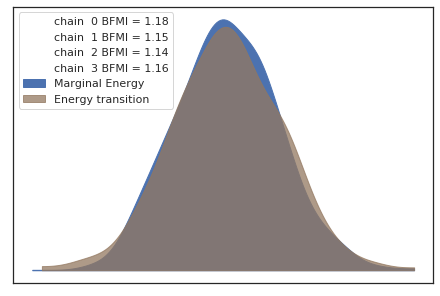

In [66]:
az.plot_energy(expressive_vocab_4_trace)

In [81]:
exp_vocab_table = az.summary(expressive_vocab_4_trace, 
                             var_names=['β', 'option_after_6mo']).set_index(pd.Index(labels + ['OPTION < 6mo'])).iloc[:, :4]

In [82]:
exp_vocab_table.to_csv('exp_vocab_EI.csv')

## Receptive Vocabulary Model

In [30]:
receptive_vocab_dataset = analysis_subset[(analysis_subset.domain=='Receptive Vocabulary')]

In [31]:
receptive_vocab_4 = generate_model(receptive_vocab_dataset, 4)

/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_age_amp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_family_inv contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_sib contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in x_3mo contains missing values and will be automatically impu

In [33]:
with receptive_vocab_4:
    
    receptive_vocab_4_trace = sample(iterations, tune=tuning)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ, β, z_school, σ_school, μ_school, p_mother_college, p_6mo, p_3mo, p_sib, p_family_inv, x_age_amp_missing, p_age_amp, s_age_amp, m_age_amp]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_3mo_missing, x_6mo_missing, x_mother_college_missing]


The number of effective samples is smaller than 25% for some parameters.


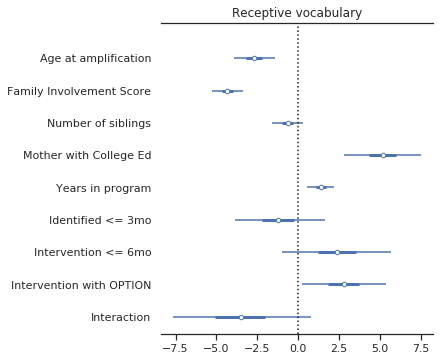

In [34]:
_,axes = az.plot_forest(receptive_vocab_4_trace, 
               var_names=['β'],
              combined=True)
axes[0].set_title('Receptive vocabulary')
axes[0].vlines(0, *axes[0].get_ylim(), linestyles='dotted')
axes[0].set_yticklabels(labels[::-1]);

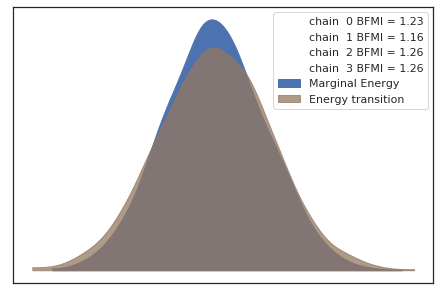

In [35]:
az.plot_energy(receptive_vocab_4_trace)

In [36]:
rec_vocab_table = az.summary(receptive_vocab_4_trace, 
                             var_names=['β', 'option_after_6mo']).set_index(pd.Index(labels + ['OPTION < 6mo'])).iloc[:, :4]

In [37]:
rec_vocab_table.to_csv('rec_vocab_EI.csv')